# Numerical implementation of Dirac
SageMath script.  (But probably could be just plain Python with some minor adjustment).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [2]:
## Pauli and Gamma matrices

In [3]:
def pauli(i):
    one = matrix([[1,0],[0,1]])
    zero = matrix([[0,0], [0,0]])
    p1 = matrix([[0,1],[1,0]])
    p2 = matrix([[0,-1j],[1j,0]])
    p3 = matrix([[1,0],[0,-1]])
    d = {1: p1, 2: p2, 3: p3}
    return d[i]
show(pauli(1), pauli(2) ,pauli(3))

[0 1]
[1 0] [  0.000000000000000 -1.00000000000000*I]
[ 1.00000000000000*I   0.000000000000000] [ 1  0]
[ 0 -1]

In [4]:
def compose(a,b,c,d):
    # a b
    # c d
    return matrix(
        np.vstack([
            np.hstack([a,b]),
            np.hstack([c,d])
    ]))
def test_compose():
    a = matrix([[0,1],[1,0]])
    b = matrix([[0,-1j],[1j,0]])
    show(compose(a, b, b, a))
test_compose()

[   0.0    1.0    0.0 -1.0*I]
[   1.0    0.0  1.0*I    0.0]
[   0.0 -1.0*I    0.0    1.0]
[ 1.0*I    0.0    1.0    0.0]

In [5]:
def gamma(i):
    # The four gamma matrices
    zero = matrix([[0,0], [0,0]])
    one = matrix([[1,0],[0,1]])
    if i == 0:
        return compose(one, zero, zero, -one)
    else:
        return compose(zero, pauli(i), -pauli(i), zero)
show(gamma(0), gamma(1), gamma(2), gamma(3))

[ 1  0  0  0]
[ 0  1  0  0]
[ 0  0 -1  0]
[ 0  0  0 -1] [ 0  0  0  1]
[ 0  0  1  0]
[ 0 -1  0  0]
[-1  0  0  0] [   0.0    0.0    0.0 -1.0*I]
[   0.0    0.0  1.0*I    0.0]
[   0.0  1.0*I    0.0    0.0]
[-1.0*I    0.0    0.0    0.0] [ 0  0  1  0]
[ 0  0  0 -1]
[-1  0  0  0]
[ 0  1  0  0]

In [6]:
def normalise(phi):
    a = np.sum(phi * np.conjugate(phi))
    return phi / sqrt(a)

def test_normalise():
    phi = np.zeros((6,6,6,4), np.cdouble)
    phi[3,3,3,0] = 4.j
    print(phi[3,3,3,0])
    phi_n = normalise(phi)
    print(phi_n[3,3,3,0])
    
test_normalise()
    

4j
1j


## Define Phi(t+1) as a function of Phi(t)

$i \hbar \gamma^\mu \partial_\mu \Psi - m \Psi = 0$

So rearanging for $\partial\Psi_t$

$\partial\Psi_t = -\frac{i}{\hbar}(\gamma^0 m + \gamma^k \partial_k) \Psi$, $k=1,2,3$

$\partial\Psi_t = -\frac{i}{\hbar}(m \gamma^0 \Psi + \gamma^k \partial_k \Psi)$


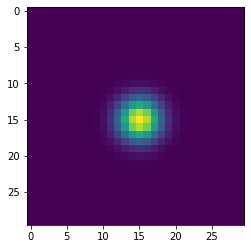

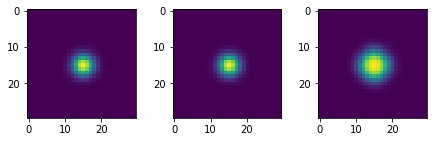

In [7]:
def advance(phi4, m, dt=1):
    # phy4 is a field defined over x,y,z, with as 4-spinor at each point
    # phy4[x,y,z,s]  where s in 0..3
    assert phi4.ndim == 4
    # x,y,z gradients by shift (roll) and subtract
    dx = (np.roll(phi4, 1, 0) - np.roll(phi4, -1, 0)) / 2
    dy = (np.roll(phi4, 1, 1) - np.roll(phi4, -1, 1)) / 2
    dz = (np.roll(phi4, 1, 2) - np.roll(phi4, -1, 2)) / 2
    
    ddt = -1.j * (
        np.einsum('is,xyzs->xyzi', gamma(0), phi4) * m + 
        np.einsum('is,xyzs->xyzi', gamma(1), dx) + 
        np.einsum('is,xyzs->xyzi', gamma(2), dy) + 
        np.einsum('is,xyzs->xyzi', gamma(3), dz))
    
    return phi4 + ddt * dt
    
def test_advance():
    s=30
    hs=s//2
    phi0 = np.zeros((s,s,s,4))
    phi0[hs,hs,hs,0] = 1
    phi0[:,:,:,0] = gaussian_filter(phi0[:,:,:,0], 2)
    plt.imshow(phi0[hs,:,:,0])
    phi0 = np.array(phi0, np.cdouble)
    phi0 = normalise(phi0)
    
    m = 0
    nsteps = 4
    
    plt.figure(figsize=(10, 2))
    phi = phi0
    for step in range(1, nsteps):
        plt.subplot(1, nsteps, step)
        plt.imshow(real_part(phi[:,:,hs,0]))
        phi = normalise(advance(phi, m))
    plt.show()
test_advance()
    

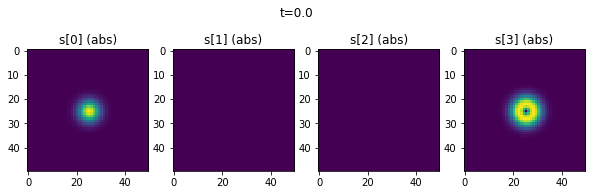

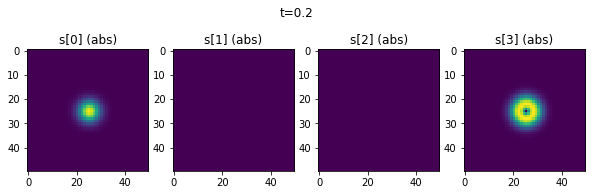

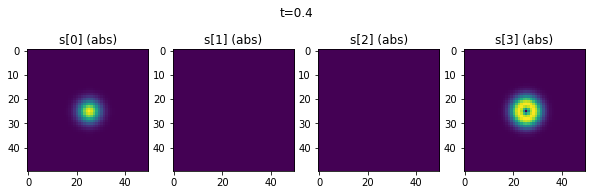

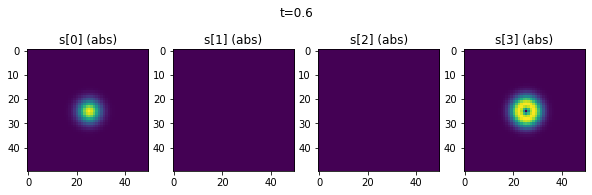

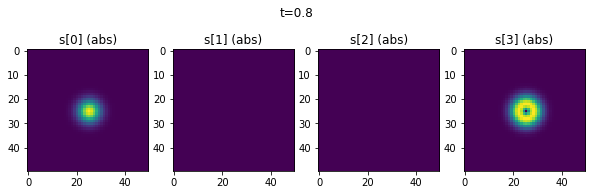

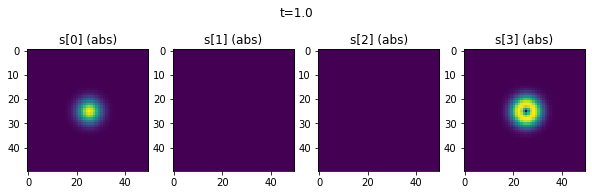

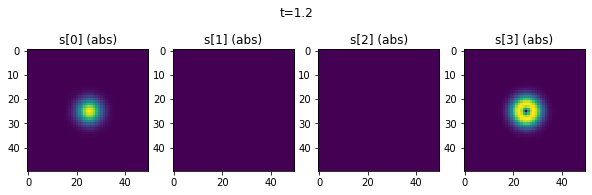

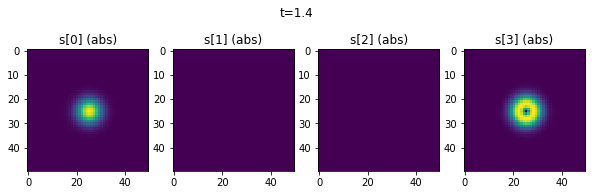

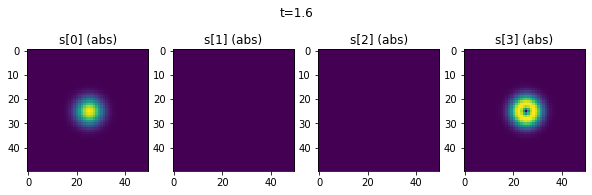

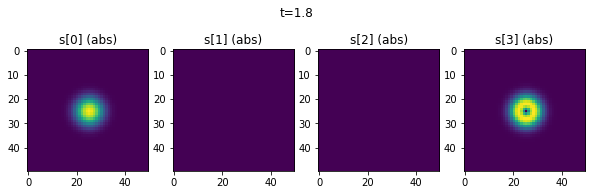

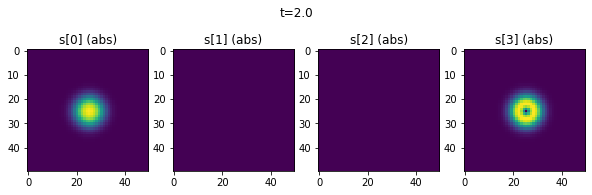

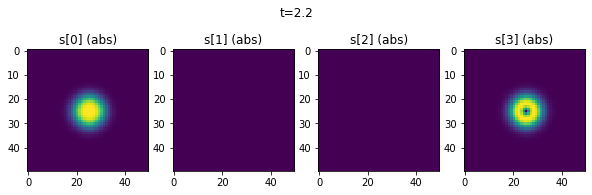

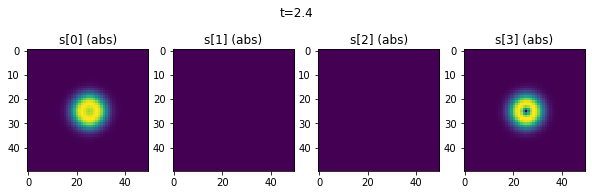

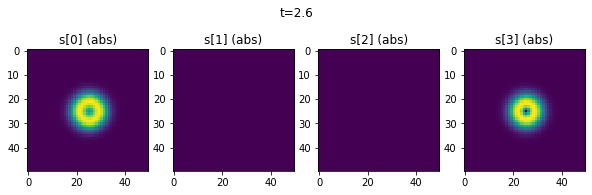

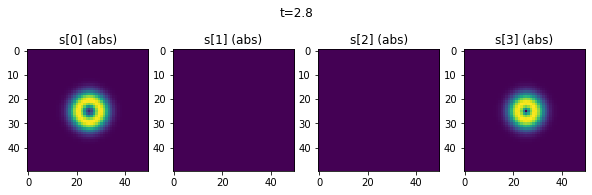

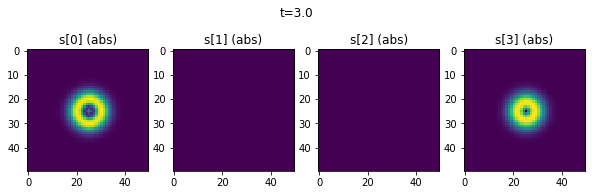

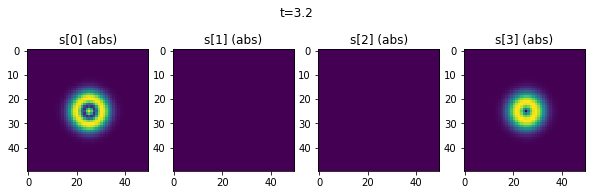

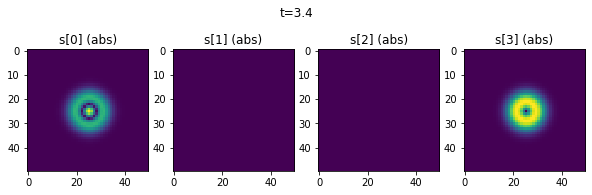

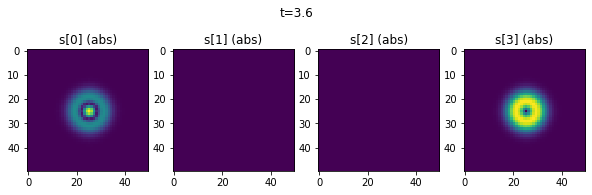

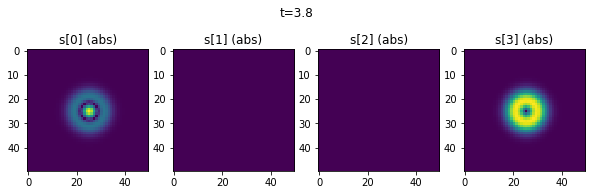

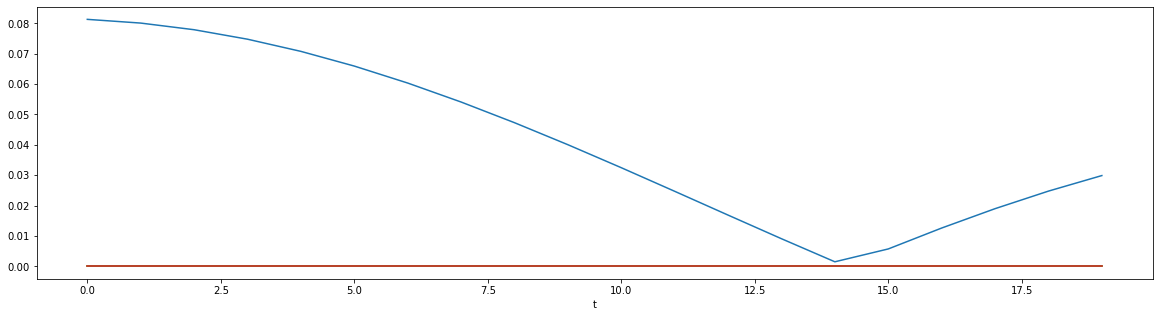

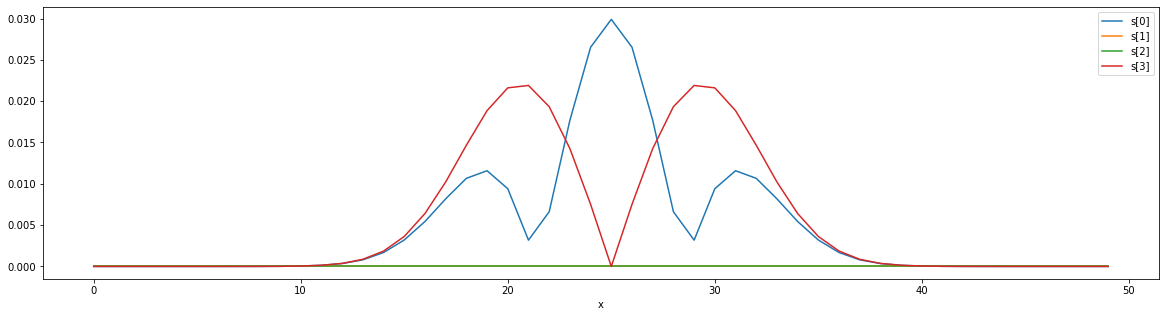

In [10]:
s=50
hs=s//2
blur=3
nsteps = 20
m=0
dt=0.2

phi0 = np.zeros((s,s,s,4))
phi0[hs,hs,hs,0] = 1
phi0[:,:,:,0] = gaussian_filter(phi0[:,:,:,0], blur)
phi0 = np.array(phi0, np.cdouble)
phi0 = normalise(phi0)    

phi = phi0
p0 = []
p1 = []
p2 = []
p3 = []


for step in range(0, nsteps):
    phi = normalise(advance(phi, m, dt=dt))
    p0 += [abs(phi[hs,hs,hs,0])]
    p1 += [abs(phi[hs,hs,hs,1])]
    p2 += [abs(phi[hs,hs,hs,2])]
    p3 += [abs(phi[hs,hs,hs,3])]
    plt.figure(figsize=(10,3))
    for p in (0,1,2,3):
        plt.subplot(1, 4, p + 1)
        plt.title(f"s[{p}] (abs)")
        plt.imshow(abs(phi[:,:,hs,p]))  
    plt.suptitle(f"t={float(step*dt):.1f}")
    plt.show()
        
plt.figure(figsize=(20,5))
for p in (p0, p1, p2, p3):
    plt.plot(p)

plt.xlabel('t')
plt.show()

plt.figure(figsize=(20,5))
plt.plot(abs(phi[:,hs,hs,0]), label='s[0]')
plt.plot(abs(phi[:,hs,hs,1]), label='s[1]')
plt.plot(abs(phi[:,hs,hs,2]), label='s[2]')
plt.plot(abs(phi[:,hs,hs,3]), label='s[3]')
plt.xlabel('x')
plt.legend()
plt.show()